In [32]:
'''
!pip install hyperopt
!pip3 install bayesian_optimization==1.4.0
!pip3 install colorama==0.4.4
!pip install skopt
'''

'\n!pip install hyperopt\n!pip3 install bayesian_optimization==1.4.0\n!pip3 install colorama==0.4.4\n!pip install skopt\n'

In [113]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, fbeta_score
from sklearn.metrics import precision_recall_curve,auc
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost.sklearn")

In [34]:
def normalize2(row, mean_df, std_df, athlete_id):
    mu = mean_df.loc[athlete_id]
    su = std_df.loc[athlete_id]
    z = (row - mu)/su
    return z

In [35]:
def getMeanStd(data):
    mean = data[data['injury'] == 0].groupby('Athlete ID').mean()
    std = data[data['injury'] == 0].groupby('Athlete ID').std()
    std.replace(to_replace=0.0, value=0.01, inplace=True)
    return mean, std

In [ ]:
def getBalancedSubset(X_train, samplesPerClass):
    healthySet   = pd.DataFrame()
    unhealthySet = pd.DataFrame()
    

    stats = pd.DataFrame(X_train[['Athlete ID','injury']].groupby(['Athlete ID','injury']).size().reset_index(name='counts'))
    stats = pd.DataFrame(stats[['Athlete ID']].groupby(['Athlete ID']).size().reset_index(name='counts'))
    #stats.drop(stats[stats['counts'] < 2].index, inplace=True)
    athleteList = stats['Athlete ID'].unique()

    samplesPerAthlete = int(np.floor(samplesPerClass) / len(athleteList))

    for athlete in athleteList:
        if unhealthySet.empty:
            unhealthySet = X_train[(X_train['Athlete ID'] == athlete) & (X_train['injury'] == 0)].sample(samplesPerAthlete, replace=True)
        else:
            unhealthySet = pd.concat([unhealthySet, X_train[(X_train['Athlete ID'] == athlete) & (X_train['injury'] == 0)].sample(samplesPerAthlete,replace=True)], ignore_index=True)
        if healthySet.empty:
            healthySet = X_train[(X_train['Athlete ID'] == athlete) & (X_train['injury'] == 1)].sample(samplesPerAthlete, replace=True)
        else:
            healthySet = pd.concat([healthySet, X_train[(X_train['Athlete ID'] == athlete) & (X_train['injury'] == 1)].sample(samplesPerAthlete,replace=True)], ignore_index=True)


    balancedSet = pd.concat([healthySet, unhealthySet], ignore_index=True)
    return balancedSet

In [90]:
def prepare_balanced_data(df,test_athletes):

    X_test_original = df[df['Athlete ID'].isin(test_athletes)].copy() # Keep a copy for normalization
    X_train_original = df[~df['Athlete ID'].isin(test_athletes)].copy() # Keep a copy

    X_train_means, X_train_std = getMeanStd(X_train_original)
    X_test_means, X_test_std = getMeanStd(X_test_original)
    X_train_balanced = getBalancedSubset(X_train_original.copy(), 4096)
    
    # Set target variable for testing and training
    y_train = X_train_balanced['injury']
    y_test = X_test_original['injury']

    # Apply normalization to the balanced training data
    X_train_norm = X_train_balanced.apply(lambda x: normalize2(x, X_train_means, X_train_std, x['Athlete ID']), axis=1)
    X_train_norm = X_train_norm.drop(columns=['injury', 'Date', 'Athlete ID'], errors='ignore')

    # Apply normalization to the test data using the testing statistics
    # Note this is a source of data leakage! but the alternative is not feasible
    X_test_norm = X_test_original.apply(lambda x: normalize2(x, X_test_means, X_test_std, x['Athlete ID']), axis=1)
    X_test_norm = X_test_norm.drop(columns=['injury', 'Date', 'Athlete ID'], errors='ignore')


    return y_train, y_test, X_train_norm, X_test_norm


In [91]:
def preparedata(df,test_athletes):

    X_test_original = df[df['Athlete ID'].isin(test_athletes)].copy() # Keep a copy for normalization
    X_train_original = df[~df['Athlete ID'].isin(test_athletes)].copy() # Keep a copy

    X_train_means, X_train_std = getMeanStd(X_train_original)
    X_test_means, X_test_std = getMeanStd(X_test_original)
    
    # Set target variable for testing and training
    y_train = X_train_original['injury']
    y_test = X_test_original['injury']

    # Apply normalization to the training data
    X_train_norm = X_train_original.apply(lambda x: normalize2(x, X_train_means, X_train_std, x['Athlete ID']), axis=1)
    X_train_norm = X_train_norm.drop(columns=['injury', 'Date', 'Athlete ID'], errors='ignore')

    # Apply normalization to the test data using the testing statistics
        # Note this is a source of data leakage!! but the alternative is not feasible
    X_test_norm = X_test_original.apply(lambda x: normalize2(x, X_test_means, X_test_std, x['Athlete ID']), axis=1)
    X_test_norm = X_test_norm.drop(columns=['injury', 'Date', 'Athlete ID'], errors='ignore')


    return y_train, y_test, X_train_norm, X_test_norm

In [ ]:
def fbeta_obj(y_true, y_pred):
    """
    Custom objective function for Hyperopt to minimize (1 - fbeta).
    """
    beta = 2
    fbeta = fbeta_score(y_true, (y_pred > 0.5).astype(int), beta=beta)
    loss = -fbeta  # We want to minimize (1 - fbeta)
    return loss

def fbeta_eval(y_pred, dtrain):
    """
    Custom evaluation metric for XGBoost to report Fbeta score.
    """
    beta = 2
    y_true = dtrain.get_label()
    fbeta = fbeta_score(y_true, (y_pred > 0.5).astype(int), beta=beta)
    return 'fbeta', fbeta


In [143]:
def objective(space, X_train, y_train, X_test, y_test):
    """
    Objective function for Hyperopt to minimize (1 - aucpr).

    Args:
        space (dict): A dictionary of hyperparameters to tune.
        X_train (pd.DataFrame or np.ndarray): The training feature data.
        y_train (pd.Series or np.ndarray): The target variable of the training data.
        X_test (pd.DataFrame or np.ndarray): The testing feature data.
        y_test (pd.Series or np.ndarray): The target variable of the testing data.
        
    Returns:
        dict: The loss (1-aucpr), status, and predicted values.
    """
    
    model = XGBClassifier(
        objective='binary:logistic',
        # eval_metric=fbeta_eval,
        use_label_encoder=False,
        #scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        **space
    )

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    # precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    #aucpr = auc(recall, precision)
    #loss = 1- aucpr  # Minimize (1 - aucpr)
    fbeta = fbeta_obj(y_test, y_pred)
    loss = fbeta

    return {'loss': loss, 'status': STATUS_OK, 'fbeta': fbeta_score, 'y_pred_proba': y_pred_proba}

In [144]:
def tune_xgboost(X_train, y_train, X_test, y_test, max_evals=20):
    """
    Tunes the hyperparameters of an XGBoost model using Bayesian optimization.

    Args:
        X_train (pd.DataFrame or np.ndarray): The training feature data.
        y_train (pd.Series or np.ndarray): The target variable of the training data.
        X_test (pd.DataFrame or np.ndarray): The testing feature data.
        y_test (pd.Series or np.ndarray): The target variable of the testing data.
        max_evals (int, optional): The maximum number of evaluations for Hyperopt. Defaults to 10.

    Returns:
        tuple: (best_params, trials)
            - best_params (dict): The best hyperparameters found.
            - trials (Trials): The trials object from Hyperopt containing all results.
    """
    
    space = {
        'learning_rate': hp.uniform('learning_rate', 0.1, 1.0),
        'n_estimators': hp.randint('n_estimators', 100, 1000),
        'max_depth': hp.randint('max_depth', 1, 10),
        'min_child_weight': hp.randint('min_child_weight', 1, 10),
        'subsample': hp.uniform('subsample', 0.01, 0.10),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
        'reg_alpha': hp.uniform('reg_alpha', 0.01, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0.01, 1.0),
        'scale_pos_weight': hp.uniform('scale_pos_weight', 1.0, 80.0)
    }
    '''
    space = {
        'learning_rate': hp.uniform('learning_rate', 0.75, 1.0),
        'n_estimators': hp.randint('n_estimators', 100, 700),
        'max_depth': hp.randint('max_depth', 4, 9),
        'min_child_weight': hp.randint('min_child_weight', 1, 10),
        'subsample': hp.uniform('subsample', 0.1, 0.8),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    }
    '''
    trials = Trials()

    best = fmin(fn=lambda space: objective(space, X_train, y_train, X_test, y_test),
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    best_params = XGBClassifier(
        objective='binary:logistic',
        #eval_metric=fbeta_eval,
        use_label_encoder=False,
        #scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        **best
    ).get_params()  # Get the parameters in a suitable format

    return best_params, trials

In [134]:
def plot_hyperparameter_vs_loss(trials, hyperparameter):
    """
    Plots the loss vs. a given hyperparameter from the Hyperopt trials object.

    Args:
        trials (hyperopt.Trials): The trials object from Hyperopt.
        hyperparameter (str): The name of the hyperparameter to plot.
    """

    losses = trials.losses()
    hyperparameter_values = [trial['misc']['vals'][hyperparameter][0] for trial in trials.trials]

    plt.scatter(hyperparameter_values, losses)
    plt.xlabel(hyperparameter)
    plt.ylabel("Loss (-fbeta)")
    plt.title(f"{hyperparameter} vs. Loss")
    plt.show()

In [145]:
def main_train(X_train, y_train, X_test, y_test, max_evals=20):
    """
    Main function to run the XGBoost hyperparameter tuning and evaluation.

    Args:
        X_train (pd.DataFrame or np.ndarray): The training feature data.
        y_train (pd.Series or np.ndarray): The target variable of the training data.
        X_test (pd.DataFrame or np.ndarray): The testing feature data.
        y_test (pd.Series or np.ndarray): The target variable of the testing data.
    """

    best_params, trials = tune_xgboost(X_train, y_train, X_test, y_test, max_evals=max_evals) # You can change max_evals

    print("Best Hyperparameters:")
    print(best_params)

    # Train the final model with the best hyperparameters
    final_model = XGBClassifier(**best_params)
    final_model.fit(X_train, y_train)

    # Evaluate the final model on the test set
    y_pred_proba = final_model.predict_proba(X_test)[:, 1]
    y_pred = final_model.predict(X_test)
    #precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    #aucpr = auc(recall, precision)
    fbeta = fbeta_score(y_test, y_pred, beta=2)
    
    print(f"Final Model Loss (fbeta): {fbeta:.4f}")
    #print(f"Final Model PR AUC on Test Set: {aucpr:.4f}")
    plot_hyperparameter_vs_loss(trials, 'learning_rate')
    plot_hyperparameter_vs_loss(trials, 'n_estimators')
    plot_hyperparameter_vs_loss(trials, 'min_child_weight')
    plot_hyperparameter_vs_loss(trials, 'subsample')
    plot_hyperparameter_vs_loss(trials, 'colsample_bytree')
    plot_hyperparameter_vs_loss(trials, 'max_depth')
    plot_hyperparameter_vs_loss(trials, 'reg_alpha')
    plot_hyperparameter_vs_loss(trials, 'reg_lambda')
    plot_hyperparameter_vs_loss(trials, 'scale_pos_weight')
    
    #  You can add code here to save the model, the predictions, or the trials object if needed.
    return final_model, fbeta

100%|██████████| 50/50 [03:04<00:00,  3.69s/trial, best loss: 0.0]
Best Hyperparameters:
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.37312349328796246, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.990606477761814, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 3, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 573, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': 0.9360592164801752, 'reg_lambda': 0.11739484978040655, 'sampling_method': None, 'scale_pos_weight': 60.58014849084457, 'subsample': 

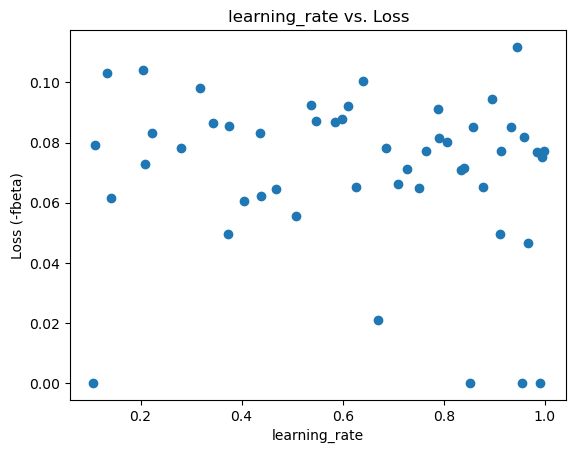

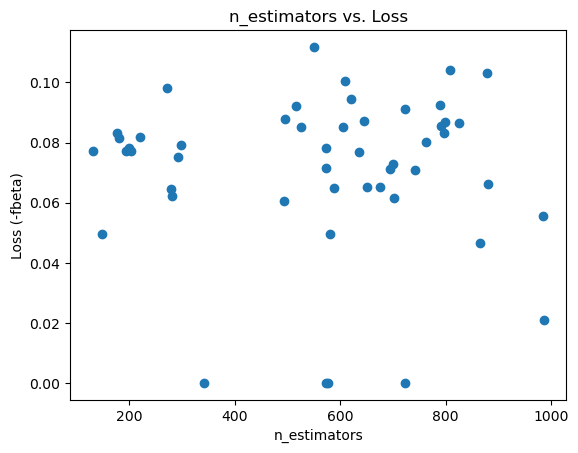

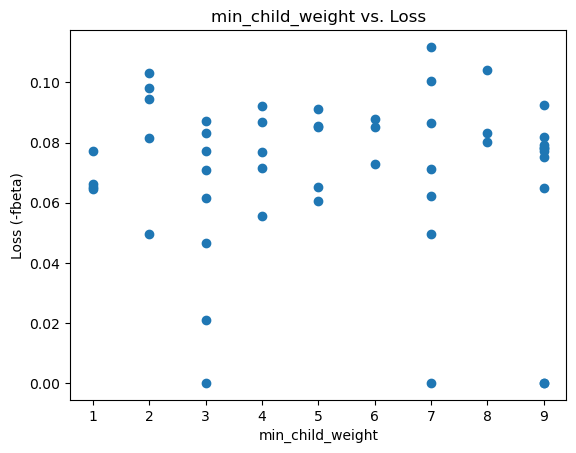

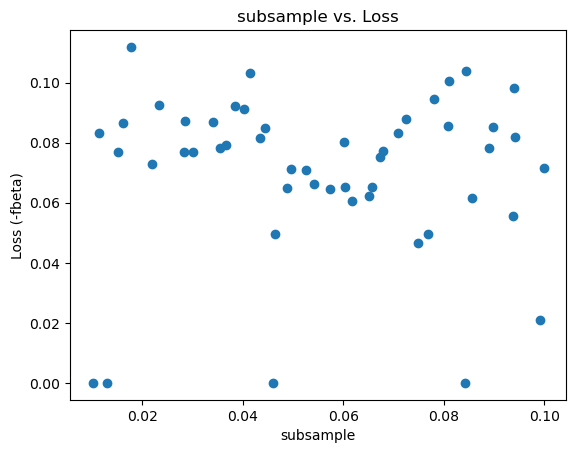

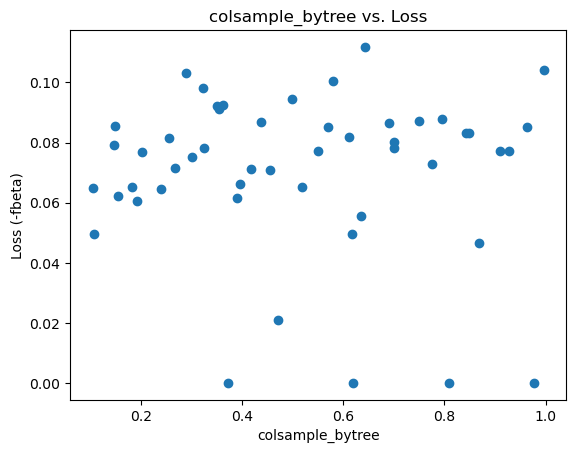

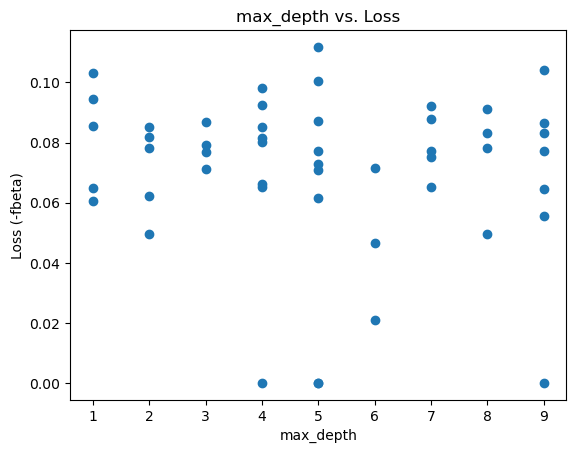

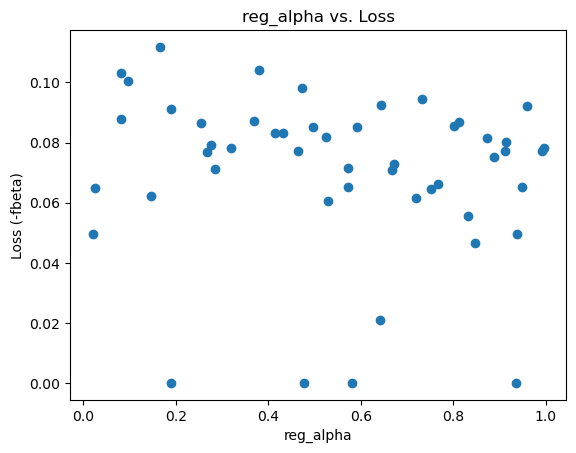

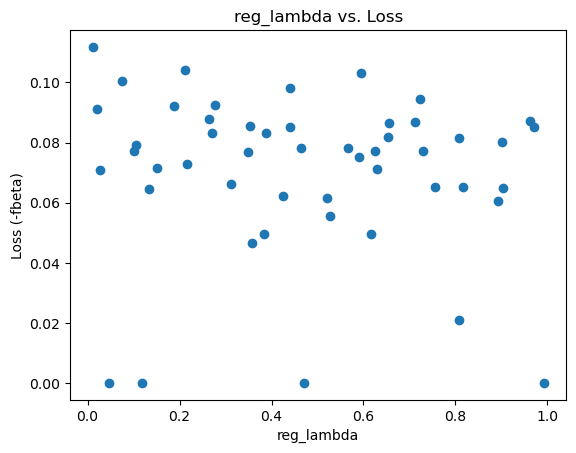

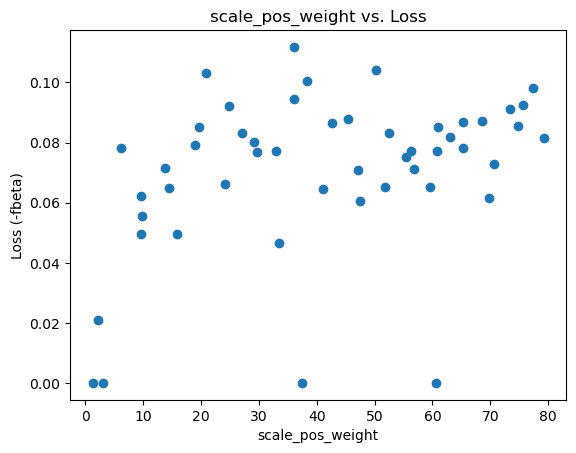

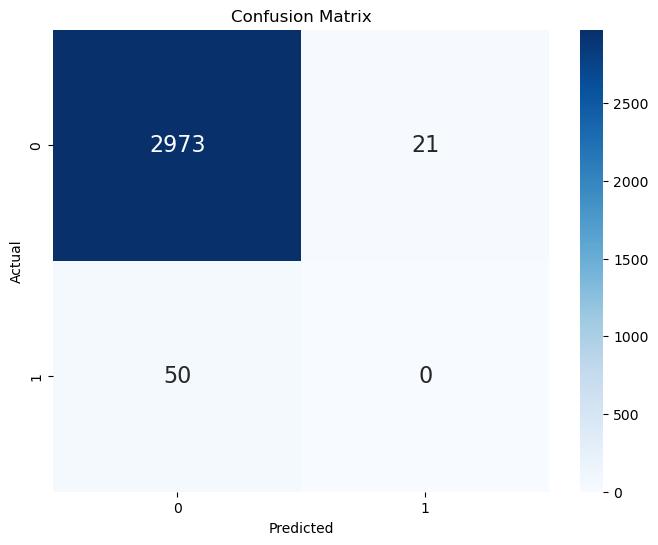

In [146]:
dfday = pd.read_csv('../data/raw/day_approach.csv')
dfday.drop(list(dfday.filter(regex = 'perceived|sprinting|strength')), axis = 1, inplace = True)
athletes = sorted(list(dfday['Athlete ID'].unique()))
test_athletes = athletes[len(athletes) - 10:]
y_train, y_test, X_train, X_test = preparedata(dfday, test_athletes)
final_model, final_aucpr = main_train(X_train, y_train, X_test, y_test,max_evals = 30)
y_pred = final_model.predict(X_test)
threshold = 0.6
y_pred = (final_model.predict_proba(X_test)[:,1] >= threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

below used for previous implementation


In [6]:
def train_model(X_train, y_train):
    xgbc = XGBClassifier()
    xgbc.fit(X_train, y_train)
    return xgbc

### main

In [ ]:
dfday = pd.read_csv('../data/raw/day_approach.csv')
dfday.drop(list(dfday.filter(regex = 'perceived|sprinting|strength')), axis = 1, inplace = True)
athletes = sorted(list(dfday['Athlete ID'].unique()))
test_athletes = athletes[len(athletes) - 10:]
y_train, y_test, X_train, X_test = preparedata(dfday, test_athletes)
model = train_model(X_train, y_train)
y_pred = model.predict(X_test)

In [10]:
'''y_train, y_test, X_train, X_test = preparedata(dfday, test_athletes)
model = train_model(X_train, y_train)
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)
'''

'y_train, y_test, X_train, X_test = preparedata(dfday, test_athletes)\nmodel = train_model(X_train, y_train)\ny_pred = model.predict(X_test)\nconfusion_matrix(y_test, y_pred)\n'

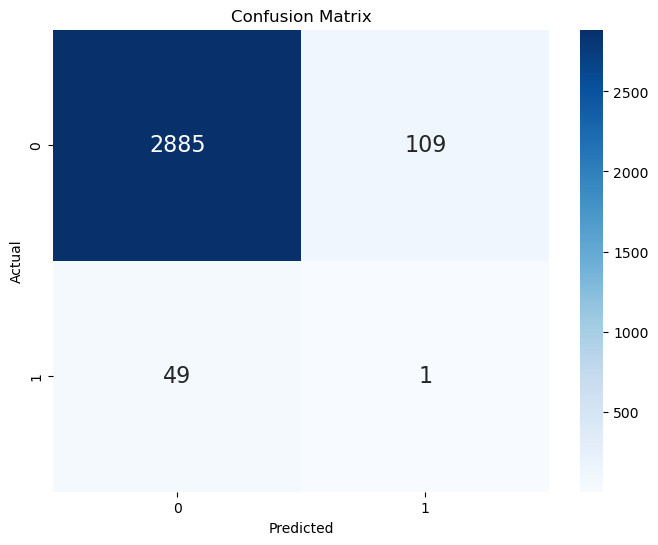

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()